In [231]:
import torch
from torch import nn, optim
import numpy as np
import xarray as xr
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [270]:
models = {'taumat':{'60':{},'80':{},'100':{}},
          'kapmat':{'60':{},'80':{},'100':{}},
          'dr0mat':{'60':{},'80':{},'100':{}}}

In [287]:
path = '/home/claire/research/PyGEM-EB/pygem_eb/data/'
fn = 'drygrainsize(SSAin=60).nc'
ds_60 = xr.open_dataset(path+fn)
ds_80 = xr.open_dataset(path+fn.replace('60','80'))
ds_100 = xr.open_dataset(path+fn.replace('60','100'))
ds = ds_60
initSSA = '60'
var = 'taumat' # kapmat, taumat or dr0mat

In [288]:
# ds_60 = ds_60.assign_coords({'initialSSA':np.array([60])})
# ds_80 = ds_80.assign_coords({'initialSSA':np.array([80])})
# ds_100 = ds_100.assign_coords({'initialSSA':np.array([100])})
# ds = xr.combine_nested([ds_60,ds_80,ds_100],'initialSSA')
# ds = ds_60

In [289]:
T = ds.coords['TVals'].to_numpy()
p = ds.coords['DENSVals'].to_numpy()
dTdz = ds.coords['DTDZVals'].to_numpy()
# initialSSA = ds.coords['initialSSA'].to_numpy()
TT,pp,ddTT = np.meshgrid(T,p,dTdz)
X = np.array([TT.flatten(),pp.flatten(),ddTT.flatten()]).T
y = []
for tpd in X:
    tsel = tpd[0]
    psel = tpd[1]
    dtsel = tpd[2]
    y.append(ds.sel(TVals=tsel,DENSVals=psel,DTDZVals=dtsel)[var].to_numpy())
y = np.array(y)

### CHECK Y VALUES

In [290]:
print('y min: ',y.min())
print('y max: ',y.max())
transform='log'

if transform == 'log':
    y = np.log(y)
    print('log y min: ',y.min())
    print('log y max: ',y.max())

y min:  2.3976113e-32
y max:  73087530.0
log y min:  -72.80825
log y max:  18.107168


### VISUALIZE DATA

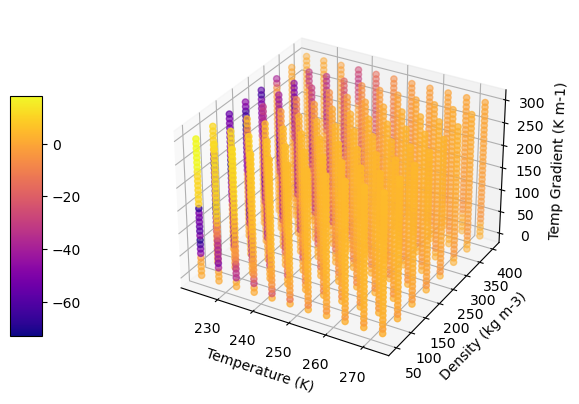

In [291]:
fig = plt.figure()
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=y.min(),vmax=y.max())
ax = plt.axes(projection='3d')
sc = ax.scatter3D(TT.flatten(),pp.flatten(),ddTT.flatten(),c=y,cmap=cmap)
cax = fig.add_axes([0,0.2,0.05,0.5])
fig.colorbar(sc, cax=cax,orientation='vertical')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Density (kg m-3)')
ax.set_zlabel('Temp Gradient (K m-1)')
plt.show()

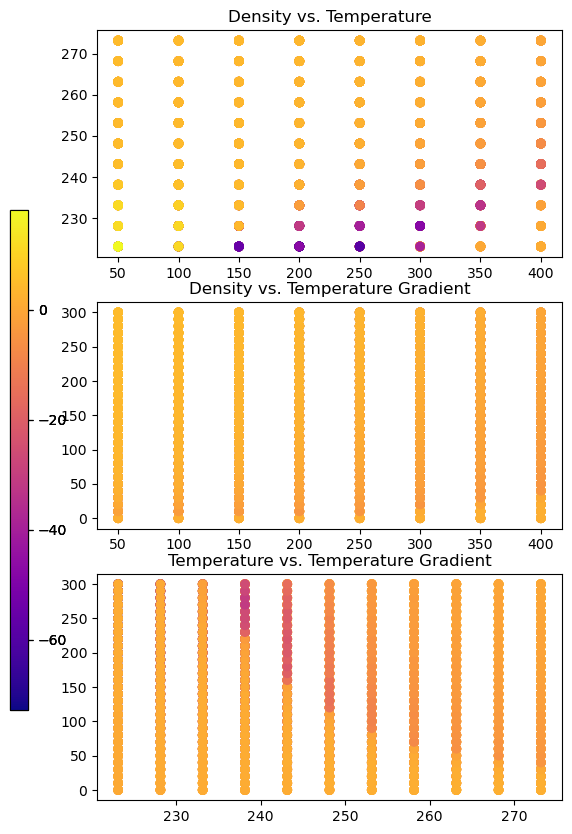

In [292]:
def subplots(pp,TT,ddTT,y,y_model=False,compare=False,t=''):
    if not compare:
        fig,axes = plt.subplots(3,figsize=(6,10))
    else:
        fig,axes = plt.subplots(3,2,figsize=(12,10))

    cmap = plt.get_cmap('plasma')

    plot1 = [pp.flatten(),TT.flatten()]
    plot2 = [pp.flatten(),ddTT.flatten()]
    plot3 = [TT.flatten(),ddTT.flatten()]
    plots = [plot1,plot2,plot3]
    names = ['Density vs. Temperature','Density vs. Temperature Gradient',
             'Temperature vs. Temperature Gradient']
    labels = [['Density','Temperature'],['Density','Temperature Gradient'],
              ['Temperature','Temperature Gradient']]

    for i,ax in enumerate(axes):
        if not compare:
            sc = ax.scatter(plots[i][0],plots[i][1],c=y,cmap=cmap)
            ax.set_title(names[i])
        else:
            sc = ax[0].scatter(plots[i][0],plots[i][1],c=y,cmap=cmap)
            sc = ax[1].scatter(plots[i][0],plots[i][1],c=y_model,cmap=cmap)
            ax[0].set_ylabel(labels[i][1])
            ax[1].set_ylabel(labels[i][1])
            ax[0].set_xlabel(labels[i][0])
            ax[1].set_xlabel(labels[i][0])
            axes[0,0].set_title('Ground Truth')
            axes[0,1].set_title('Model')
        cax = fig.add_axes([-0.02,0.2,0.03,0.5])
        fig.colorbar(sc, cax=cax,orientation='vertical')

    # axes[0].set_title('Density vs. Temperature')
    # axes[1].scatter(pp.flatten(),ddTT.flatten(),color=cmap(y))
    # axes[1].set_title('Density vs. Temperature Gradient')
    # axes[2].scatter(TT.flatten(),ddTT.flatten(),color=cmap(y))
    # axes[2].set_title('Temperature vs. Temperature Gradient')

    # if compare:
    #     axes[4].scatter(pp.flatten(),TT.flatten(),color=cmap(y_model))
    #     axes[4].set_title('MODEL Density vs. Temperature')
    #     axes[5].scatter(pp.flatten(),ddTT.flatten(),color=cmap(y_model))
    #     axes[5].set_title('MODEL Density vs. Temperature Gradient')
    #     axes[6].scatter(TT.flatten(),ddTT.flatten(),color=cmap(y_model))
    #     axes[6].set_title('MODEL Temperature vs. Temperature Gradient')
    plt.title(t)
    plt.show()
    return
subplots(pp,TT,ddTT,y)

In [293]:
def RMSE(y,pred):
    N = len(y)
    RMSE = np.sqrt(np.sum(np.square(pred-y))/N)
    return RMSE

for var in list(models.keys()):
    path = '/home/claire/research/PyGEM-EB/pygem_eb/data/'
    fn = 'drygrainsize(SSAin=##).nc'.replace('##',str(initSSA))
    ds = xr.open_dataset(path+fn)

    # extract X values (temperature, density, temperature gradient)
    T = ds.coords['TVals'].to_numpy()
    p = ds.coords['DENSVals'].to_numpy()
    dTdz = ds.coords['DTDZVals'].to_numpy()
    
    # form meshgrid and corresponding y for model input
    TT,pp,ddTT = np.meshgrid(T,p,dTdz)
    X = np.array([TT.flatten(),pp.flatten(),ddTT.flatten()]).T
    y = []
    for tpd in X:
        tsel = tpd[0]
        psel = tpd[1]
        dtsel = tpd[2]
        y.append(ds.sel(TVals=tsel,DENSVals=psel,DTDZVals=dtsel)[var].to_numpy())
    y = np.array(y)

    # dr0 can be modeled linearly; kappa and tau should be log transformed
    transform = 'none' if var=='dr0mat' else 'log'
    if transform == 'log':
        y = np.log(y)

    # randomly select training and testing data to store statistics
    np.random.seed(9)
    percent_train = 90
    N = len(y)
    train_mask = np.zeros_like(y,dtype=np.bool_)
    train_mask[np.random.permutation(N)[:int(N*percent_train / 100)]] = True
    X_train = X[train_mask,:]
    X_val = X[np.logical_not(train_mask),:]
    y_train = y[train_mask].reshape(-1,1)
    y_val = y[np.logical_not(train_mask)].reshape(-1,1)

    # train rain forest model
    rf = RandomForestRegressor(max_depth=15,n_estimators=10)
    y_train = y_train.flatten()
    rf.fit(X_train,y_train)
    trainloss = RMSE(y_train,rf.predict(X_train))
    valloss = RMSE(y_val,rf.predict(X_val))

    models[var][str(initSSA)]['rf'] = rf
    models[var][str(initSSA)]['trainloss'] = trainloss
    models[var][str(initSSA)]['valloss'] = valloss

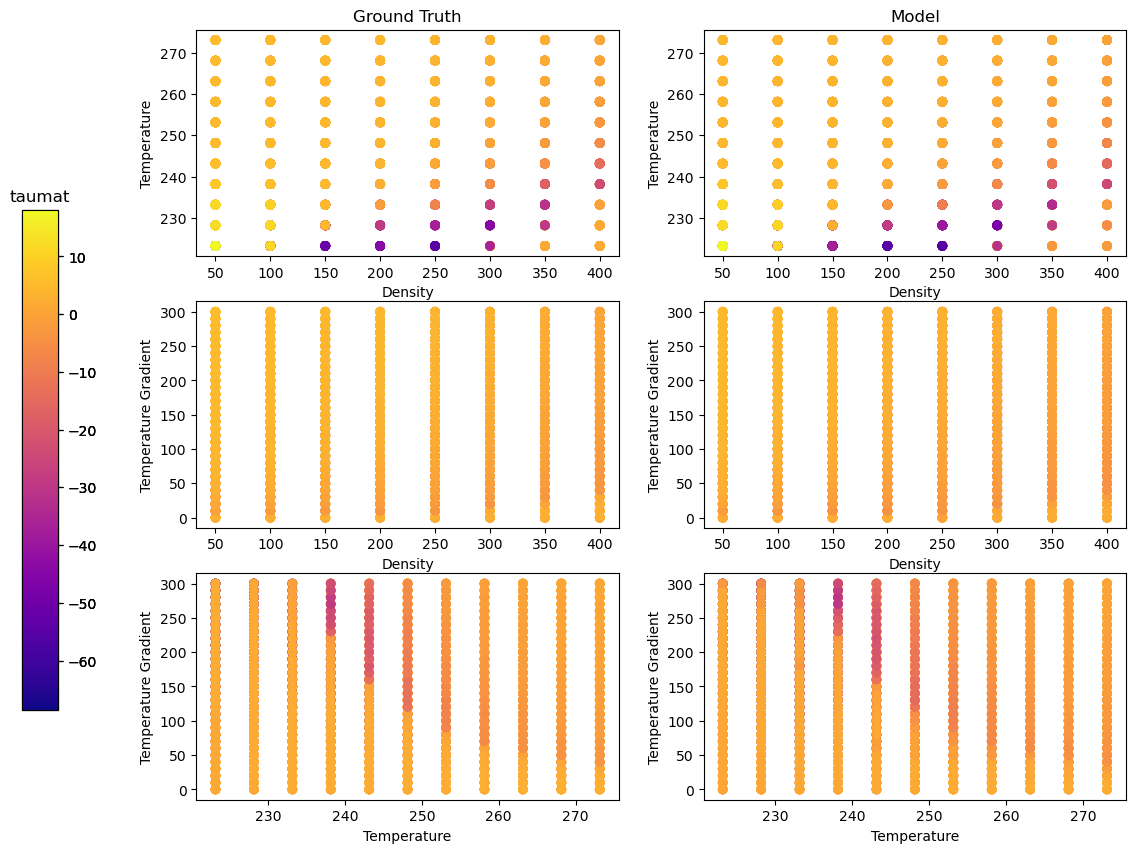

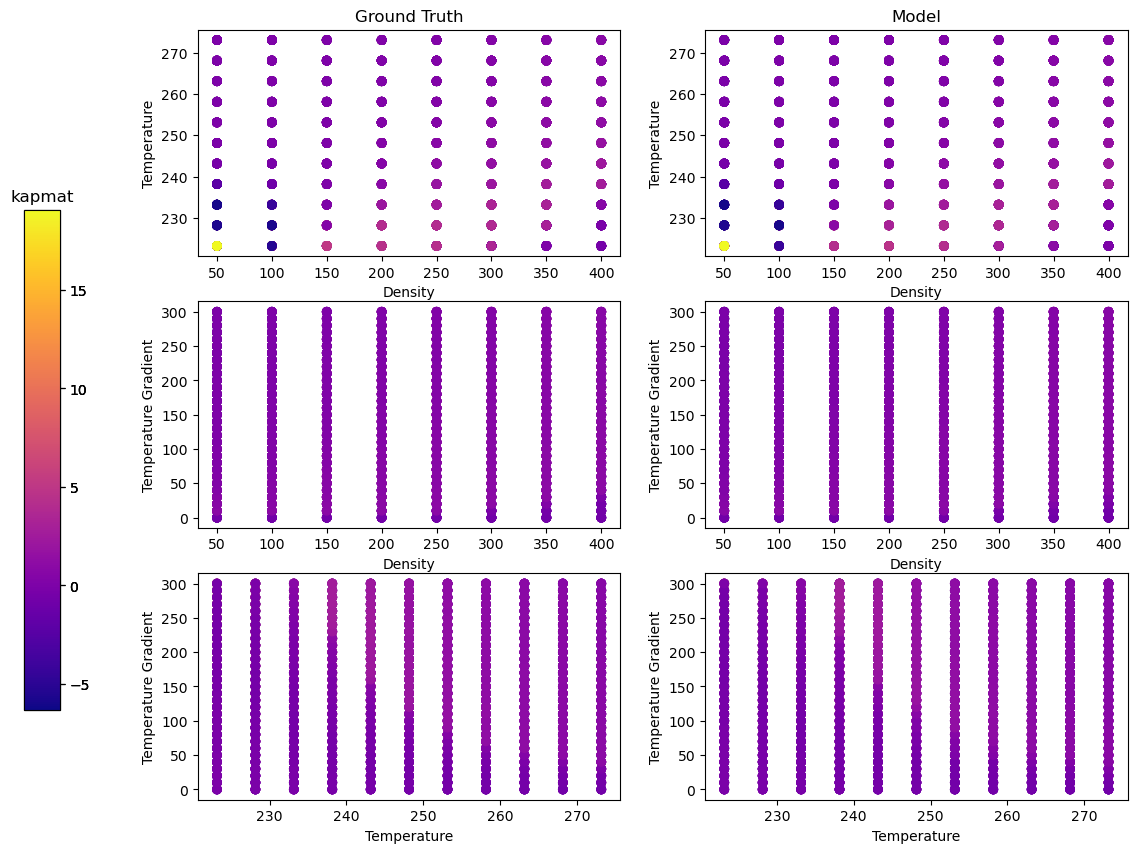

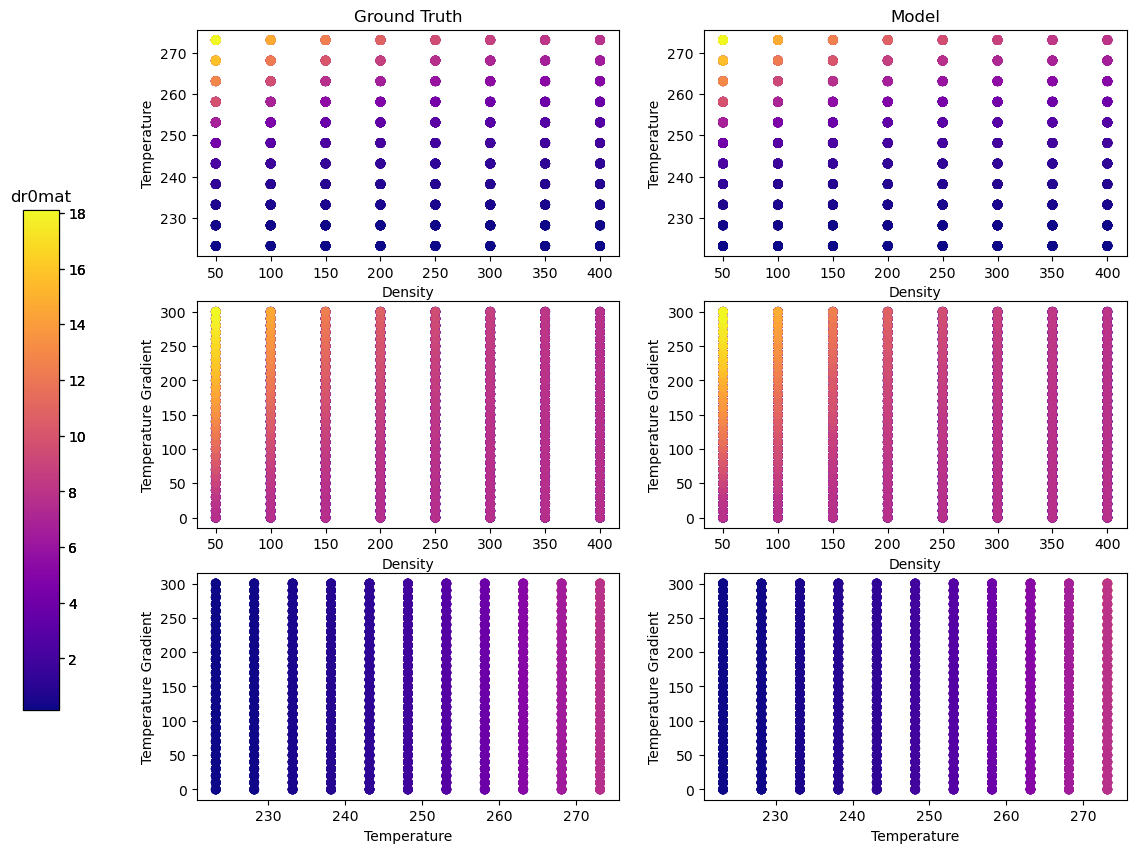

In [294]:
for var in list(models.keys()):
    TT,pp,ddTT = np.meshgrid(T,p,dTdz)
    X = np.array([TT.flatten(),pp.flatten(),ddTT.flatten()]).T
    y = []
    for tpd in X:
        tsel = tpd[0]
        psel = tpd[1]
        dtsel = tpd[2]
        y.append(ds.sel(TVals=tsel,DENSVals=psel,DTDZVals=dtsel)[var].to_numpy())
    y = np.array(y)

    # dr0 can be modeled linearly; kappa and tau should be log transformed
    transform = 'none' if var=='dr0mat' else 'log'
    if transform == 'log':
        y = np.log(y)
    y_out = models[var][str(initSSA)]['rf'].predict(torch.Tensor(X))
    subplots(pp,TT,ddTT,y,y_out,True,t=var)

In [295]:
models

{'taumat': {'60': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 1.9634406369876682,
   'valloss': 315.60326856803493},
  '80': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 1.9634406369876682,
   'valloss': 315.60326856803493},
  '100': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 1.9634406369876682,
   'valloss': 315.60326856803493}},
 'kapmat': {'60': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 0.3204688946102128,
   'valloss': 34.38301680238115},
  '80': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 0.3204688946102128,
   'valloss': 34.38301680238115},
  '100': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 0.3204688946102128,
   'valloss': 34.38301680238115}},
 'dr0mat': {'60': {'rf': RandomForestRegressor(max_depth=15, n_estimators=10),
   'trainloss': 0.0374377760320897,
   'valloss': 76.1272298

In [296]:
p = 200
T = 270
dTdz = 5
g = 200
for SSA0 in ['60','80','100']:
    for p in [50,150,300]:
        for T in [230,250,270]:
            for dTdz in [0,100,300]:
                X = np.vstack([T,p,dTdz]).T
                tau = np.exp(models['taumat'][SSA0]['rf'].predict(X))
                kap = np.exp(models['kapmat'][SSA0]['rf'].predict(X))
                dr0 = models['dr0mat'][SSA0]['rf'].predict(X)
                drdrydt = dr0*1e-6*np.power(tau/(tau + 1e6*(g - 54.5)),1/kap)
                drdry = drdrydt * 3600 * 24 * 10**6
                if drdry > 200:
                    print('p',p,'T',T,'dTdz',dTdz,'SSA',SSA0)
                    print(drdry)

p 50 T 230 dTdz 100 SSA 60
[8905.92488527]
p 150 T 230 dTdz 100 SSA 60
[4805.32749961]
p 150 T 250 dTdz 100 SSA 60
[342.66388846]
p 300 T 230 dTdz 300 SSA 60
[4578.579707]
p 300 T 250 dTdz 100 SSA 60
[821.33468364]
p 50 T 230 dTdz 100 SSA 80
[8905.92488527]
p 150 T 230 dTdz 100 SSA 80
[4805.32749961]
p 150 T 250 dTdz 100 SSA 80
[342.66388846]
p 300 T 230 dTdz 300 SSA 80
[4578.579707]
p 300 T 250 dTdz 100 SSA 80
[821.33468364]
p 50 T 230 dTdz 100 SSA 100
[8905.92488527]
p 150 T 230 dTdz 100 SSA 100
[4805.32749961]
p 150 T 250 dTdz 100 SSA 100
[342.66388846]
p 300 T 230 dTdz 300 SSA 100
[4578.579707]
p 300 T 250 dTdz 100 SSA 100
[821.33468364]


## NEURAL NETWORK
### TRAIN MODEL

In [179]:
np.random.seed(9)
percent_train = 80
N = len(y)
train_mask = np.zeros_like(y,dtype=np.bool_)
train_mask[np.random.permutation(N)[:int(N*percent_train / 100)]] = True
X_train = torch.Tensor(X[train_mask,:])
X_val = torch.Tensor(X[np.logical_not(train_mask),:])
y_train = torch.Tensor(y[train_mask].reshape(-1,1))
y_val = torch.Tensor(y[np.logical_not(train_mask)].reshape(-1,1))
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

torch.Size([2182, 3]) torch.Size([2182, 1])
torch.Size([546, 3]) torch.Size([546, 1])


In [180]:
class Network(nn.Module):
    def __init__(self, hidden_layer_sizes=[24,24]):
        n_input = 3
        n_output = 1
        n_hidden_layers = len(hidden_layer_sizes)
        super().__init__()
    
        seq = []
        for layer in range(n_hidden_layers+1):
            if layer == 0:
                # First layer
                n_in = n_input
                n_out = hidden_layer_sizes[layer]
                activate = True
            elif layer < n_hidden_layers:
                # Middle layers
                n_in = hidden_layer_sizes[layer - 1]
                n_out = hidden_layer_sizes[layer]
                activate = True
            else:
                # Last layer
                n_in = hidden_layer_sizes[layer - 1]
                n_out = n_output
                activate = False
            seq.append(nn.Linear(n_in,n_out))
            if activate:
                seq.append(nn.ReLU())

        self.seq = nn.Sequential(*seq)

    def forward(self,xy):
        xy = self.seq(xy)
        return xy

In [181]:
def train(model, X_train, X_val, y_train, y_val, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True):
    train_hist = []
    test_hist = []
    loss_fcn = nn.MSELoss()

    opt = optim.Adam(params = model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt,gamma=gamma)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        out = model(X_train)
        train_loss = loss_fcn(out,y_train)
        train_hist.append(train_loss.item()) 

        test_loss = loss_fcn(model(X_val), y_val)
        test_hist.append(test_loss.item())

        # Print loss progress info 10 times during training
        if epoch % int(epochs / 10) == 0:
            print(f"Epoch {epoch} of {epochs}... \tAverage loss: {train_loss.item()}")
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
        scheduler.step()
    plot_loss(train_hist,test_hist)
    return

def plot_loss(train_loss, val_loss):
    plt.plot(train_loss,label="Training")
    plt.plot(val_loss,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")

Epoch 0 of 200... 	Average loss: 2213.2470703125
Epoch 20 of 200... 	Average loss: 45.80198669433594
Epoch 40 of 200... 	Average loss: 8.447861671447754
Epoch 60 of 200... 	Average loss: 3.635693073272705
Epoch 80 of 200... 	Average loss: 3.423835277557373
Epoch 100 of 200... 	Average loss: 3.2927451133728027


Epoch 120 of 200... 	Average loss: 3.2037763595581055
Epoch 140 of 200... 	Average loss: 3.1437668800354004
Epoch 160 of 200... 	Average loss: 3.095001697540283
Epoch 180 of 200... 	Average loss: 3.0538554191589355


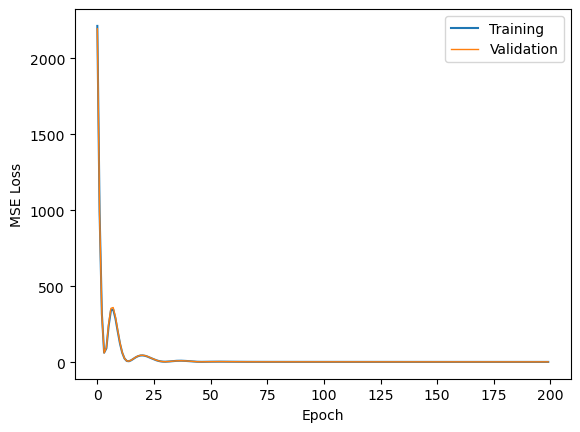

In [182]:
model = Network()
l = 0.005
e = 200
g = 1
train(model,X_train,X_val,y_train,y_val,l,e,g)

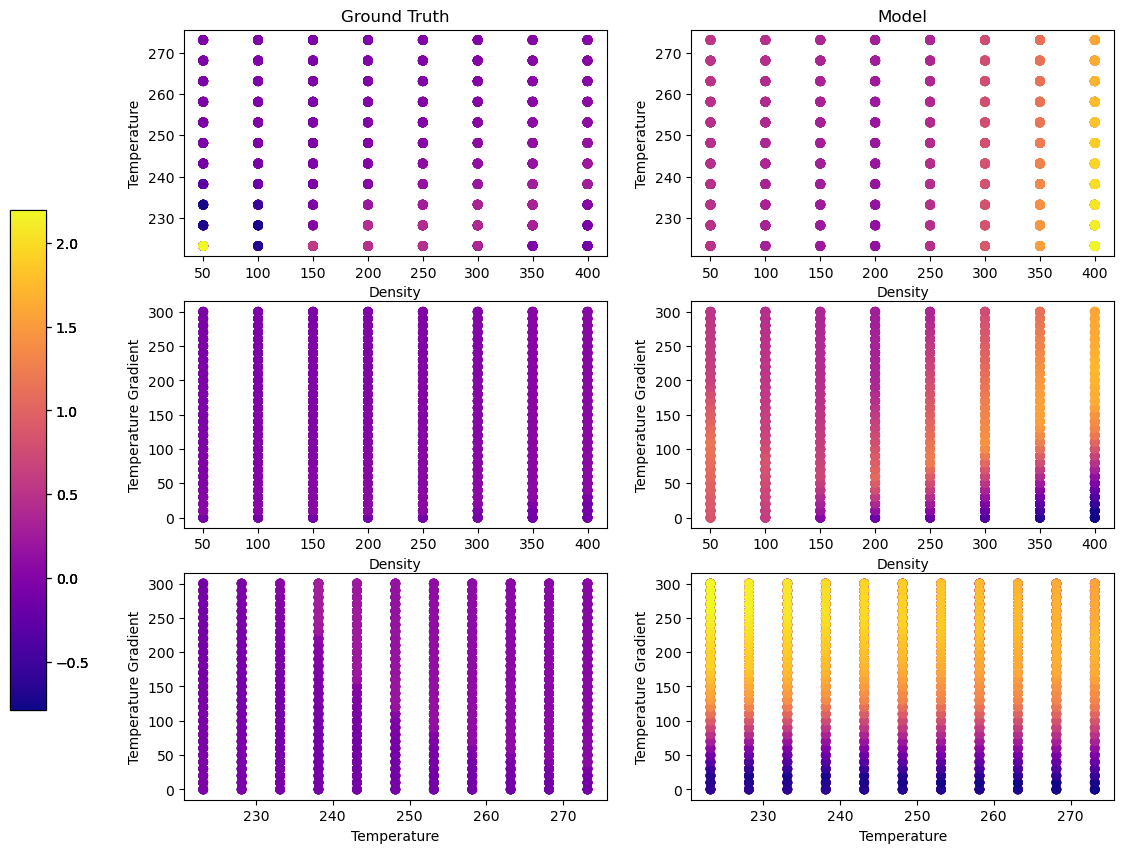

In [183]:
y_out = model(torch.Tensor(X)).detach().numpy()
subplots(pp,TT,ddTT,y,y_out,True)

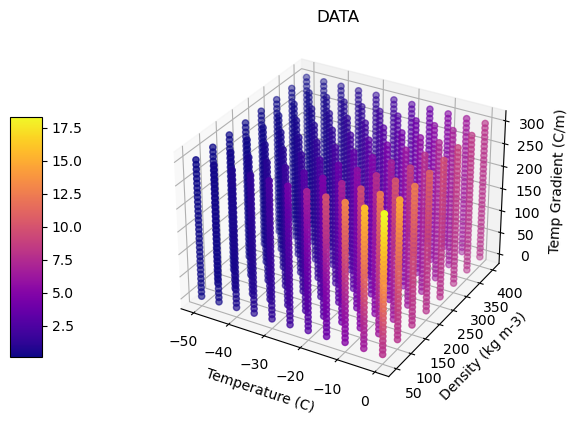

In [194]:
fig = plt.figure()
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=y.min(),vmax=y.max())
ax = plt.axes(projection='3d')
sc = ax.scatter3D(TT.flatten()-273.15,pp.flatten(),ddTT.flatten(),c=y,cmap=cmap)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Density (kg m-3)')
ax.set_zlabel('Temp Gradient (C/m)')
cax = fig.add_axes([0,0.2,0.05,0.5])
fig.colorbar(sc, cax=cax,orientation='vertical')
ax.set_title('DATA')
plt.show()

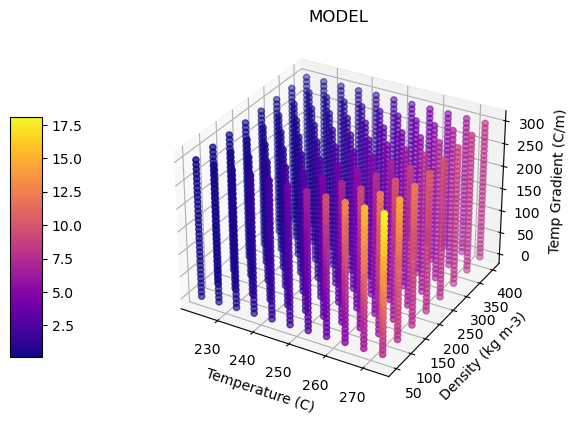

In [195]:
fig = plt.figure()
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=y_out.min(),vmax=y_out.max())
ax = plt.axes(projection='3d')
sc = ax.scatter3D(TT.flatten(),pp.flatten(),ddTT.flatten(),c=y_out,cmap=cmap)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Density (kg m-3)')
ax.set_zlabel('Temp Gradient (C/m)')
cax = fig.add_axes([0,0.2,0.05,0.5])
fig.colorbar(sc, cax=cax,orientation='vertical')
ax.set_title('MODEL')
plt.show()